In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, TensorDataset

%matplotlib inline

In [2]:
np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
data_dir = 'dataset/Notch_Dataset/'
all_file_list = os.listdir(data_dir)
file_list = []
for file in all_file_list:
    if file.endswith('csv'):
        file_list.append(file)
file_list = sorted(file_list)

In [ ]:
train = pd.DataFrame()
for i in range(5):
    data = pd.read_csv(data_dir + file_list[i])
    data['person_id'] = i+1
    train = pd.concat([train, data])
    
valid = pd.read_csv(data_dir + file_list[5])
valid['person_id'] = 6

test = pd.read_csv(data_dir + file_list[6])
test['person_id'] = 7

In [ ]:
train_obs_scaler = StandardScaler()
train_tar_scaler = StandardScaler()

test_obs_scaler = StandardScaler()
test_tar_scaler = StandardScaler()

columns = ['Acc_x [m/s^2]', 'Acc_y [m/s^2]', 'Acc_z [m/s^2]', 'AnyFall', 'person_id']

obs_train = train[['Acc_x [m/s^2]', 'Acc_y [m/s^2]', 'Acc_z [m/s^2]']]
obs_train = train_obs_scaler.fit_transform(obs_train)
tar_train = np.asarray(train['AnyFall'])
tar_train = train_tar_scaler.fit_transform(tar_train.reshape(-1, 1))

obs_train = pd.DataFrame(obs_train)
tar_train = pd.DataFrame(tar_train)
transformed_train = pd.concat([obs_train, tar_train], axis=1)
transformed_train['per-id'] = train['person_id'].values
transformed_train.columns = columns

obs_valid = valid[['Acc_x [m/s^2]', 'Acc_y [m/s^2]', 'Acc_z [m/s^2]']]
obs_valid = train_obs_scaler.fit_transform(obs_valid)
tar_valid = np.asarray(valid['AnyFall'])
tar_valid = train_tar_scaler.fit_transform(tar_valid.reshape(-1, 1))

obs_valid = pd.DataFrame(obs_valid)
tar_valid = pd.DataFrame(tar_valid)
transformed_valid = pd.concat([obs_valid, tar_valid], axis=1)
transformed_valid['per-id'] = valid['person_id'].values
transformed_valid.columns = columns

obs_test = test[['Acc_x [m/s^2]', 'Acc_y [m/s^2]', 'Acc_z [m/s^2]']]
obs_test = test_obs_scaler.fit_transform(obs_test)
tar_test = np.asarray(test['AnyFall'])
tar_test = test_tar_scaler.fit_transform(tar_test.reshape(-1, 1))

obs_test = pd.DataFrame(obs_test)
tar_test = pd.DataFrame(tar_test)
transformed_test = pd.concat([obs_test, tar_test], axis=1)
transformed_test['per-id'] = test['person_id'].values
transformed_test.columns = columns

# Data processing

In [8]:
def dataProcessing(data):
    X_data, y_data = list(), list()
    for i in range(32, len(data) - 32):
        acc_x = data['Acc_x [m/s^2]'][i-32: i]
        acc_y = data['Acc_y [m/s^2]'][i-32: i]
        acc_z = data['Acc_z [m/s^2]'][i-32: i]
        X_data.append([acc_x.values, acc_y.values, acc_z.values])
        
        outcome = data['AnyFall'][i: i+32]
        y_data.append([outcome.values])
    return X_data, y_data

In [9]:
X_train, y_train = dataProcessing(transformed_train)
X_valid, y_valid = dataProcessing(transformed_valid)
X_test, y_test = dataProcessing(transformed_test)

In [10]:
batch_size = 64

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

valid_data = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# Model

In [11]:
from model.singleLSTM import singleLSTM
from model.stackedLSTM import stackedLSTM
from model.CNN import CNN

In [12]:
def choose_model(model_type):
    if model_type == 'singleLSTM':
        model = singleLSTM(3, 320, 32).cuda()
        save_path = 'results/singleLSTM/'
        save_file_name = save_path + 'SingleLSTMNotch.pth'
    elif model_type == 'stackedLSTM':
        model = stackedLSTM(3, 320, 32).cuda()
        save_path = 'results/stackedLSTM/'
        save_file_name = save_path + 'StackedLSTMNotch.pth'
    elif model_type == 'CNN':
        model = CNN(3, [8, 16, 64], 32).cuda()
        save_path = 'results/CNN/'
        save_file_name = save_path + 'CNNNotch.pth'
    return model, save_path, save_file_name

In [13]:
model_type = 'CNN'
model, save_path, save_file_name = choose_model(model_type)
print(model)

CNN(
  (block1): Sequential(
    (0): Conv1d(3, 8, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (block3): Sequential(
    (0): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (conv1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
)


In [14]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       mode='min',
                                                       factor=0.2
                                                    )
criterion = nn.MSELoss().cuda()
patience = 5
n_epochs = 300

In [15]:
# example

with torch.no_grad():
    dataiter = iter(train_loader)
    X, y = dataiter.next()
    
    ex_model = model
    if model_type != 'CNN':
        X = X.view(-1, 32, 3)
    print('X size', X.shape)
    print('y size', y.shape)
    output = ex_model(X.cuda())
    print(output.shape)

X size torch.Size([64, 3, 32])
y size torch.Size([64, 1, 32])
torch.Size([64, 32, 1])


In [16]:
def fit(model, batch_size, n_epochs, save_file_name):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    best_loss = 9999999999
    patience = 0
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            if model_type != 'CNN':
                data, target = data.view(-1, 32, 3).cuda(), target.cuda()
            else:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            if model_type != 'CNN':
                loss = criterion(output, target.squeeze())
            else:
                loss = criterion(output.squeeze(), target.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            if model_type != 'CNN':
                data, target = data.view(-1, 32, 3).cuda(), target.cuda()
            else:
                data, target = data.cuda(), target.cuda()
            output = model(data.cuda())
            if model_type != 'CNN':
                loss = criterion(output, target.squeeze())
            else:
                loss = criterion(output.squeeze(), target.squeeze())
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
            
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = 0
            torch.save(model.state_dict(), save_file_name)
            print('Saving Model')
        else:
            patience += 1
            print('Patience for ', patience)
        if patience == 10:
            break

    model.load_state_dict(torch.load(save_file_name))

    return  model, avg_train_losses, avg_valid_losses

In [17]:
model, train_loss, valid_loss = fit(model, batch_size, n_epochs, save_file_name)

[  1/300] train_loss: 0.99403 valid_loss: 0.98454
Saving Model
[  2/300] train_loss: 0.95030 valid_loss: 0.96648
Saving Model
[  3/300] train_loss: 0.92263 valid_loss: 0.95911
Saving Model
[  4/300] train_loss: 0.90593 valid_loss: 0.95354
Saving Model
[  5/300] train_loss: 0.89319 valid_loss: 0.94799
Saving Model
[  6/300] train_loss: 0.88186 valid_loss: 0.94208
Saving Model
[  7/300] train_loss: 0.87151 valid_loss: 0.93652
Saving Model
[  8/300] train_loss: 0.86170 valid_loss: 0.93173
Saving Model
[ 15/300] train_loss: 0.79030 valid_loss: 0.92700
Patience for  3
[ 16/300] train_loss: 0.77960 valid_loss: 0.92913
Patience for  4
[ 17/300] train_loss: 0.76909 valid_loss: 0.93151
Patience for  5
[ 18/300] train_loss: 0.75874 valid_loss: 0.93435
Patience for  6
[ 19/300] train_loss: 0.74869 valid_loss: 0.93735
Patience for  7
[ 20/300] train_loss: 0.73891 valid_loss: 0.94071
Patience for  8
[ 21/300] train_loss: 0.72953 valid_loss: 0.94471
Patience for  9
[ 22/300] train_loss: 0.72068 vali

In [18]:
def evaluate_model(model, test_loader):
    test_loss = 0.0
    y_test = []
    y_hat = []
    model.eval()
    for data,target in test_loader:
        if model_type != 'CNN':
            data, target = data.view(-1, 32, 3).cuda(), target.cuda()
        else:
            data, target = data.cuda(), target.cuda()   
        output = model(data.cuda())
        loss = criterion(output.squeeze(), target.squeeze())
        test_loss += loss.item()
        y_test += list(target.squeeze().detach().cpu().numpy())
        y_hat += list(output.squeeze().detach().cpu().numpy())
        
    return test_loss/len(test_loader), y_test, y_hat

In [19]:
test_loss, y_target, y_hat = evaluate_model(model, test_loader)

In [20]:
labels = test_tar_scaler.inverse_transform(y_target)
predicted = test_tar_scaler.inverse_transform(y_hat)

In [21]:
len(y_target), len(y_hat)

(338624, 338624)

In [22]:
corrected_labels = []
for i in range(len(labels)):
    if labels[i] != 1.0:
        corrected_labels.append(0.0)
    else:
        corrected_labels.append(1.0)

In [23]:
from collections import Counter
cnt_y_hat = Counter(predicted)

thres = np.array(list(cnt_y_hat.keys())).mean()
corrected_predicted = []
for i in range(len(predicted)):
    if predicted[i] < thres:
        corrected_predicted.append(0.0)
    else:
        corrected_predicted.append(1.0)

In [24]:
print(confusion_matrix(corrected_labels, corrected_predicted))
print()
acc = accuracy_score(corrected_labels, corrected_predicted)
f1 = f1_score(corrected_labels, corrected_predicted)
recall = recall_score(corrected_labels, corrected_predicted)
precision = precision_score(corrected_labels, corrected_predicted)

print('recall score is ', recall)
print('precision score is ', precision)
print('f1 score is ', f1)
print('accuracy score is ', acc)

[[183930 121350]
 [ 17490  15854]]

recall score is  0.4754678502879079
precision score is  0.11555056703886184
f1 score is  0.18591833384149914
accuracy score is  0.589987714987715


In [25]:
result = pd.DataFrame([acc, precision, recall, f1]).T
result.columns = ['Accuracy', 'Precision', 'Recall', 'F1']
result.to_csv(save_path + 'CNNNotch.csv')

In [26]:
labels_32, predicted_32 = list(), list()
for i in range(len(labels)):
    if i % 32 == 0:
        labels_32.append(labels[i])
for i in range(len(predicted)):
    if i % 32 == 0:
        predicted_32.append(predicted[i])

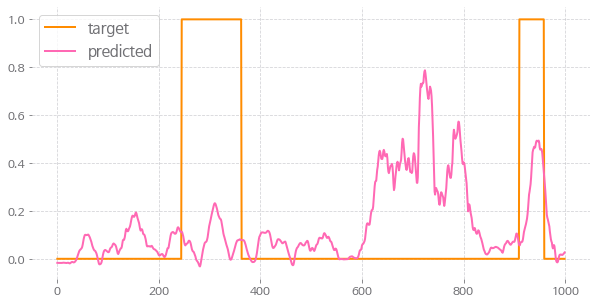

<Figure size 432x288 with 0 Axes>

In [27]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(labels_32[600:1600], label='target', color='darkorange')
plt.plot(predicted_32[600:1600], label='predicted', color='hotpink')
plt.legend(loc='upper left', fontsize=15)
plt.show()
plt.savefig(save_path + 'CNNNotch.png')